# End to end multi-class dog breed classification
This notebook builds an end to end multi class image classifier using Tensorflow 2.0 and Tensorflow Hub.

## 1.problem
Identifying the breed of a dog given an image of a dog. When I am sitting in a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2.Data
The data we are using is from kaggle's dog breed identification competition.
https://www.kaggle.com/competitions/dog-breed-identification

## 3.Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4.Features
Some information about the data:
* we are dealing with images(unstructured data), so it is probably best we use deep learning/transfer learning
* There are 120 breeds of dogs (This means there are 120 different classes).
* There are around 10,000+ images in the training set(These images have labels)
* There are around 10,000+ images in the test set(These images have no labels), because we will want to predict them.
https://www.kaggle.com/competitions/dog-breed-identification/data

Note: To Unzip the data in colab, use `!unzip "source path" -d "destination path"`

### Get the workspace ready
* Import tensorflow
* Import tensorflow hub
* make sure you are using GPU

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

#  Check for GPU availability
print("GPU", "available GPU!" if tf.config.list_physical_devices("cuda") else "not available ")

2.6.0
0.12.0
GPU not available 


In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpu_ok = tf.config.list_physical_devices('GPU')

# print(tf.test.is_gpu_available())
print("tf version:", tf.__version__)
print("use GPU:", gpu_ok)

tf version: 2.6.0
use GPU: []


In [3]:
# Getting our data ready (turning into Tensors)
# With all ML models, our data has to be in numerical format, so that is what we will do first, turning our images into tensors(Numerical representation)
#  Lets start by accessing our data and checking out the labels
# Check out the labels of our data

import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

<AxesSubplot:>

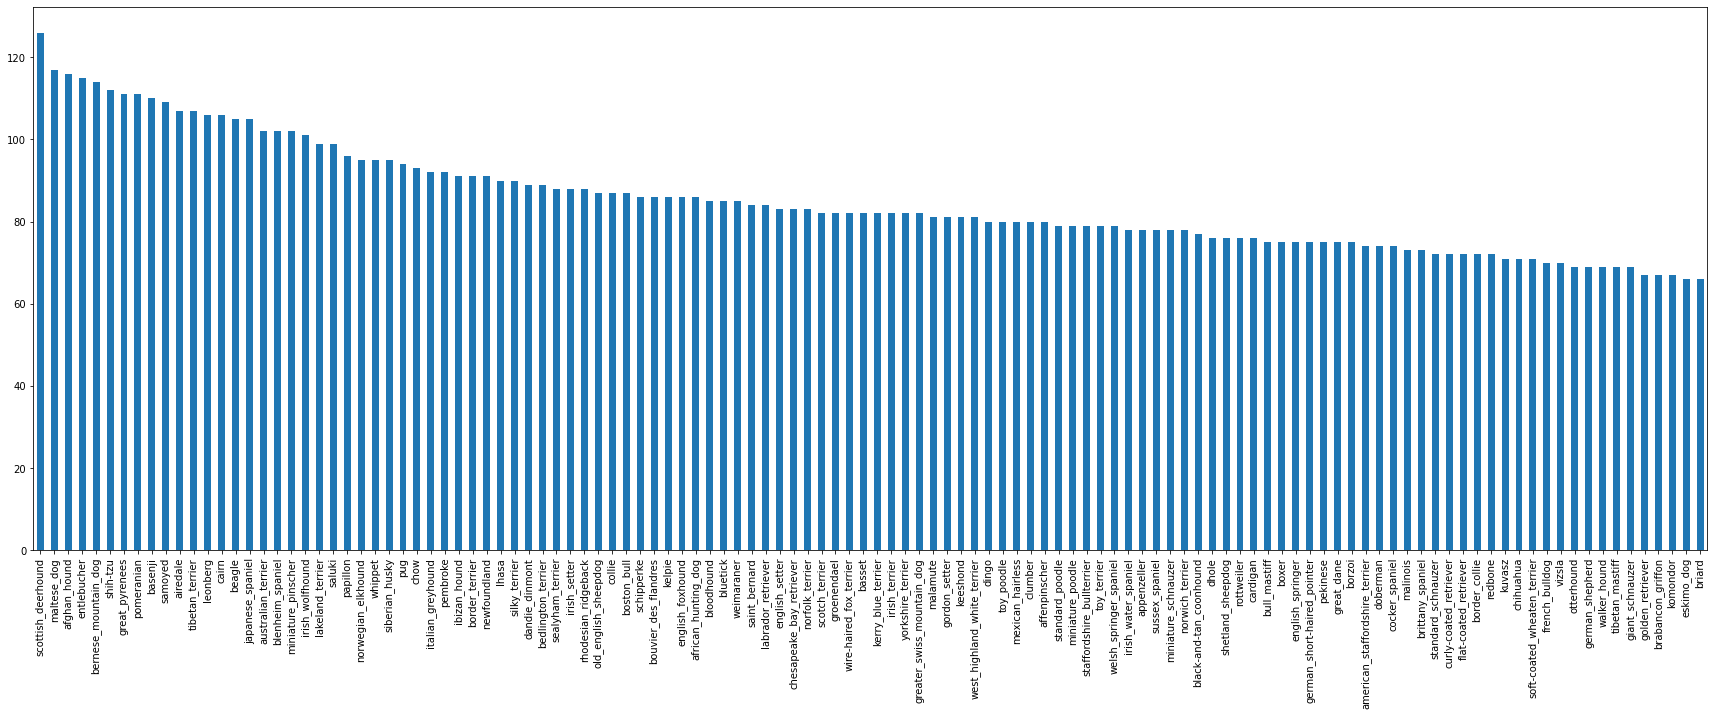

In [7]:
labels_csv["breed"].value_counts().plot.bar(figsize=(30,10))

In [8]:
labels_csv.breed.value_counts().median()

82.0

In [9]:
## Lets view an image
from IPython.display import  Image

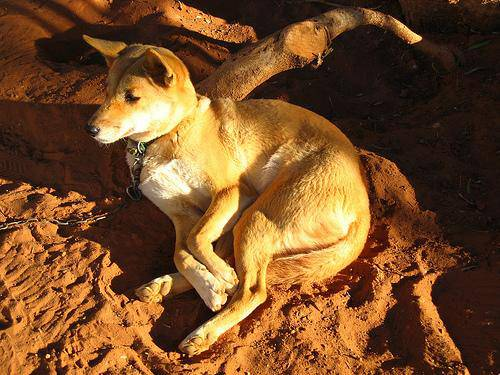

In [10]:
Image("data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [14]:
## Getting images and their labels
# Lets get a list of all of our image file path names
# Create pathname from image ID's
filenames = ["data/train/" + fname + ".jpg" for fname in labels_csv.id]
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [15]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("data/train/")) == len(filenames):
    print("File name match actual amount of files. proceed.")
else:
    print("File name do not match actual amount of files, check the target directory.")

File name match actual amount of files. proceed.


In [16]:
os.listdir("data/train/")[:10]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '0042188c895a2f14ef64a918ed9c7b64.jpg']

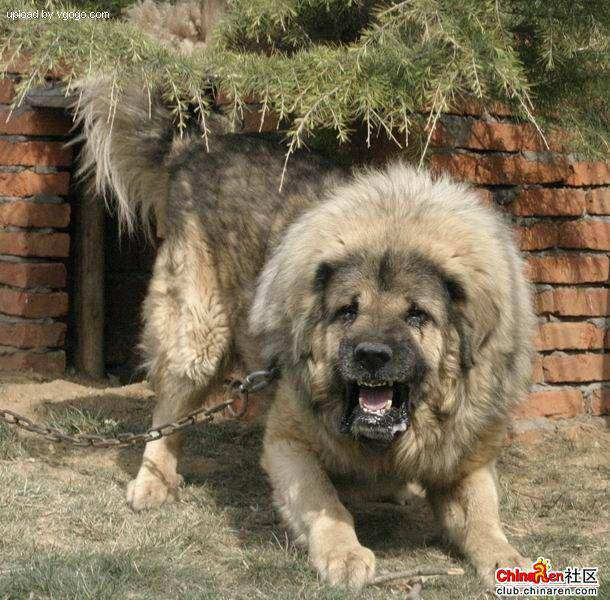

In [17]:
## One more check
Image(filenames[9000])

In [18]:
labels_csv.breed[9000]

'tibetan_mastiff'

In [25]:
# Since we got our training image file paths in a list, lets prepare our labels
import numpy as np
labels = labels_csv.breed.to_numpy()
# labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [26]:
len(labels)

10222

In [27]:
# check if the number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames")
else:
    print("Number of labels does not match the number of files, check the data directories")

Number of labels matches number of filenames


In [28]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [29]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [30]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [31]:
len(boolean_labels)

10222

In [34]:
# Example: turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0])) # this is the index where label occurs

boston_bull
(array([19], dtype=int64),)


In [35]:
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int))# there will be a 1 where the sample label occurs

19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [38]:
print(labels[2]) # Index where label occurs in boolean array
print(boolean_labels[2].astype(int))# there will be a 1 where the sample label occurs

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [39]:
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [40]:
# Creating our own validation set
# Since the dataset from kaggle doesn't come with a validation set, we will create our own.

In [41]:
# Set
# up X and Y variables
X =  filenames
y = boolean_labels


In [42]:
# We are going to start off experimenting with 1000 images and increase as needed

In [44]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param{type:"slider", min:10000, step: 1000}

In [45]:
# lets split our data into train and validation
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES


In [46]:
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

In [48]:
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [49]:
# Lets have a look at the training data
X_train[:5], y_train[:2]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

In [57]:
## Preprocessing images, turning images into Tensors
# To preprocess our images into tensors, we are going to write a function which does the followings:
# Take an image filepath as input
# use tensorflow to read the file and save it to a variable, Image.
# turn our Image (a jpg) into Tensors
# normalize out image (convert color channel values from 0-255 to 0-1)
# resize the Image to be a shape of (224,224), images of similar size
# Return the modified image

#Before we do, let's see what importing an image looks like

In [51]:
# convert an image to numpy array
from matplotlib.pyplot import  imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [52]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [53]:
image.max(), image.min()

(255, 0)

In [54]:
# Turn an image into Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [58]:
# now we have seen what an image looks like as a Tensor, let's make a function to preprocess them.
# define the image size.

IMG_SIZE = 224

# create a function for preprocess images

def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image and turns the image into a Tensor
    :param image_path:
    :return:
    """
    # read in an image file
    imge = tf.io.read_file(image_path)

    # Turn the Jpg image into numerical tensor with 3 color channels (R,G,B)
    imge = tf.image.decode_jpeg(imge, channels=3)

    # convert the colour channel values from 0-255 to 0-1 values
    imge = tf.image.convert_image_dtype(imge, tf.float32)

    # Resize the image to our desired value (224,224)
    imge = tf.image.resize(imge, size=[img_size, img_size])

    return imge